In [1]:
#| default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [4]:
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [5]:
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [6]:
# go full width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
x_train.shape

torch.Size([50000, 784])

### Initial setup

In [8]:
n,m = x_train.shape
c = y_train.max() + 1
mh = 50

In [9]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [10]:
model = Model(m, mh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

### Cross Entropy loss

In [11]:
pred.exp().sum(-1, keepdim=True).shape

torch.Size([50000, 1])

In [12]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [13]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [14]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [15]:
a = log_softmax(pred)

In [16]:
pred.max(dim=1, keepdim=True).values.shape

torch.Size([50000, 1])

In [17]:
def log_softmax(x):
    max_e = (x - x.max(dim=1, keepdim=True).values)
    return max_e - max_e.exp().sum(-1, keepdim=True).log()

In [18]:
b = log_softmax(pred)

In [19]:
b.shape, a.shape

(torch.Size([50000, 10]), torch.Size([50000, 10]))

In [20]:
a

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [21]:
b

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [22]:
test_close(a, b)

In [23]:
sm_pred = log_softmax(pred)

In [24]:
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [25]:
y_train[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [26]:
sm_pred[0,1], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.49, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [27]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [28]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [29]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [30]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In [31]:
F.softmax??

In [32]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

In [33]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), F.cross_entropy(pred, y_train), 1e-3)

log_softmax and nll_loss are combined in one function F.cross_entropy

## Basic training loop

In [34]:
loss_func = F.cross_entropy

In [35]:
bs = 50
xb = x_train[:bs]
preds = model(xb)
preds.shape

torch.Size([50, 10])

In [36]:
yb = y_train[:bs]

In [37]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [38]:
# preds

In [39]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3,
        9, 3, 5, 3, 8, 3, 5, 9, 5, 9, 5])

In [40]:
#| export
def accuracy(out, yb): return (out.argmax(dim=1) == yb).float().mean()

In [41]:
accuracy(preds, yb)

tensor(0.08)

In [42]:
lr = 0.5
epochs = 3

In [43]:
#| export
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [44]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [45]:
a = [1, 2, 3, 4, 5, 6]

In [46]:
i = iter(a)

In [47]:
s = slice(0, 50)

In [48]:
s

slice(0, 50, None)

In [49]:
x_train[s]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [50]:
#| export
# slice example
a = ("a", "b", "c", "d", "e", "f", "g", "h")
x = slice(0, 8, 3)
print(a[x])

('a', 'd', 'g')


In [51]:
list(range(1, 5, 1))

[1, 2, 3, 4]

In [52]:
for l in model.layers:
    if hasattr(l, 'weight'):
        print(l)

Linear(in_features=784, out_features=50, bias=True)
Linear(in_features=50, out_features=10, bias=True)


In [53]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs,n))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


#### Using parameters and optim

In [54]:
m1 = nn.Module()

In [55]:
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [56]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [57]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [58]:
m1.named_children??

In [59]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [60]:
model = MLP(m, mh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [61]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [62]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [63]:
s = slice(0, 5)
x = list(range(10))
x[s]

[0, 1, 2, 3, 4]

In [64]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -=p.grad * lr
                model.zero_grad()
        
        report(loss, preds, yb)

In [65]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [66]:
model.zero_grad??

In [67]:
from typing import Any


class Frob:
    def __init__(self) -> None:
        self.abc = 'abc'
        
    def __setattr__(self, name: str, value: Any) -> None:
        self.__dict__[name] = value.upper()

f = Frob()
f.bamf = "bamf"

In [68]:
f.abc

'ABC'

In [69]:
from typing import Any


class Module:
    def __init__(self, n_in, nh, n_out) -> None:
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k: str, v: Any) -> None:
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self) -> str:
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [70]:
mdl = Module(m, mh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [71]:
type(list(mdl._modules.values())[0].parameters())

generator

### Registering modules

In [72]:
from functools import reduce

In [73]:
reduce??

In [74]:
reduce(lambda x,y: x + y, [1, 2, 3,4, 5])

15

In [75]:
class Module(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
    
    def forward(self, x):
        return reduce(lambda val,layer: layer(val), self.layers, x)

In [76]:
# nn.Module.add_module??

In [77]:
layers = [nn.Linear(m,mh), nn.ReLU(), nn.Linear(mh, 10)]

In [78]:
model = Module(layers)

In [79]:
# model.named_modules??

In [80]:
model(xb).shape

torch.Size([50, 10])

In [81]:
# nn.ModuleList

In [82]:
# nn.Sequential

In [83]:
model = nn.Sequential(
    nn.Linear(m, mh),
    nn.ReLU(),
    nn.Linear(mh, 10)
)

In [84]:
fit()

0.16, 0.94
0.13, 0.96
0.08, 0.96


In [85]:
loss_func(model(xb), yb)

tensor(0.03, grad_fn=<NllLossBackward0>)

In [86]:
accuracy(model(xb), yb)

tensor(1.)

In [87]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [88]:
slice??

### Optim

In [89]:
class Optimizer():
    def __init__(self, params, lr=0.5) -> None:
        self.params,self.lr = list(params),lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr * p.grad
    
    def zero_grad(self):
        for p in self.params: p.grad.zero_()

In [90]:
model = nn.Sequential(
    nn.Linear(m, mh),
    nn.ReLU(),
    nn.Linear(mh, 10)
)

In [91]:
opt = Optimizer(model.parameters())

In [92]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


In [93]:
from torch import optim

In [94]:
def get_model():
    model = nn.Sequential(
        nn.Linear(m, mh),
        nn.ReLU(),
        nn.Linear(mh, 10)
    )
    return model, optim.SGD(model.parameters(), lr=lr)

In [95]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [96]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


### Dataset and dataloader

In [380]:
#| export
class Dataset():
    def __init__(self, x, y):
        self.x, self.y  = x,y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i): return self.x[i], self.y[i]

In [381]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [99]:
assert len(train_ds) == len(x_train)

In [100]:
assert len(valid_ds) == len(x_valid)

In [101]:
xb, yb = train_ds[:5]

In [102]:
len(xb), len(yb)

(5, 5)

In [103]:
xb.shape

torch.Size([5, 784])

In [104]:
model, opt = get_model()

In [105]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = train_ds[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


In [106]:
a = torch.ones(2, 2)
a.zero_()

tensor([[0., 0.],
        [0., 0.]])

In [107]:
class DataLoader():
    def __init__(self, ds, bs) -> None:
        self.ds,self.bs = ds,bs
    
    def __iter__(self):
        for i in range(0, len(self.ds), bs):
            yield self.ds[i: i+self.bs]

In [108]:
a = list(range(10))
a[5:15]

[5, 6, 7, 8, 9]

In [109]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [110]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [111]:
a = [1, 2, 3,4]
i = iter(a)
next(i)

1

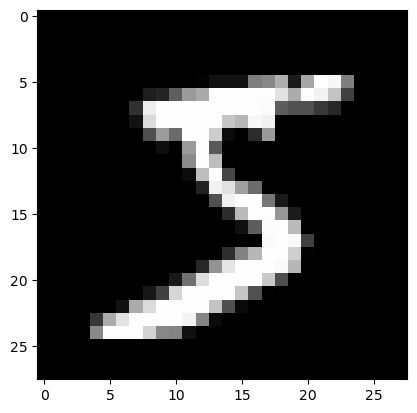

In [112]:
plt.imshow(xb[0].view(28, 28))

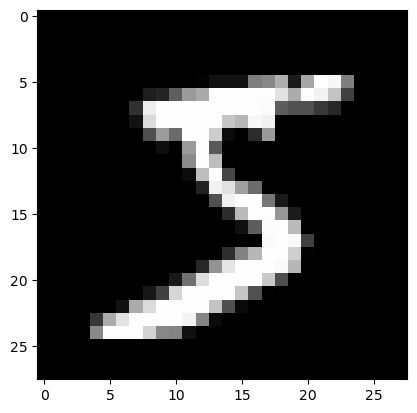

In [113]:
plt.imshow(xb[0].reshape(28, 28))

In [114]:
yb[0]

tensor(5)

In [115]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        report(loss, preds, yb)

In [116]:
model, opt = get_model()

In [117]:
fit()

0.11, 0.98
0.08, 0.98
0.06, 1.00


In [118]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.18, grad_fn=<NllLossBackward0>), tensor(0.96))

### Random sampling

In [119]:
import random

In [120]:
class Sampler():
    def __init__(self, ds, shuffle=False) -> None:
        self.n,self.shuffle = len(ds), shuffle
    
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [121]:
from itertools import islice

In [122]:
ss = Sampler(train_ds)

In [123]:
it = iter(ss)
for o in range(5):
    print(next(it))

0
1
2
3
4


In [124]:
islice??

In [125]:
slice??

In [126]:
slice(0, 10, 2)

slice(0, 10, 2)

In [127]:
a = list(range(10))
type(a[slice(0, 10, 2)])

list

In [128]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [129]:
for i in ss:
    print(i)
    if i == 2:
        break

0
1
2


In [130]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[33981, 19214, 28003, 34581, 23189]

In [131]:
import fastcore.all as fc

In [132]:
fc.store_attr??

In [133]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False) -> None:
        fc.store_attr()
    
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [134]:
batchs = BatchSampler(ss, 4)
a = list(islice(batchs, 5))

In [135]:
train_ds[next(islice(batchs, 5))]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([6, 4, 5, 0]))

In [136]:
def collate(b):
    xs, ys = zip(*b)
    print(len(xs))

In [137]:
collate(train_ds[i] for i in batchs)

12500


In [138]:
len(train_ds)

50000

In [139]:
zip??

In [140]:
b = [(1, 2), (3, 4), (4, 5)]

In [141]:
x, y = zip(*b)
x, y

((1, 3, 4), (2, 4, 5))

In [142]:
a = tensor([1, 2, 3, 4])
b = torch.zeros(4)

In [143]:
torch.stack((a, b)).shape

torch.Size([2, 4])

In [144]:
torch.stack??

In [145]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [302]:
class DataLoader():
    def __init__(self, ds, batchs1, collate_fn=collate):
        fc.store_attr()
    
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs1)

In [303]:
BatchSampler??

Init signature: BatchSampler(sampler, bs, drop_last=False) -> None
Docstring:      <no docstring>
Type:           type
Subclasses:     

In [304]:
train_sampler = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_sampler = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [305]:
train_dl = DataLoader(train_ds, batchs1=train_sampler)
valid_dl = DataLoader(valid_ds, batchs1=valid_sampler)

In [306]:
next(iter(train_dl))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 9, 6, 6, 8, 1, 6, 7, 9, 0, 6, 1, 1, 1, 9, 8, 4, 9, 7, 1, 1, 1, 3, 3, 1, 6, 9, 4, 9, 8, 0, 7, 0, 0, 5, 9, 0, 8, 9,
         8, 0, 4, 7, 2, 1, 2, 1, 8, 0, 1]))

In [308]:
def g1():
    for i in range(10):
        yield i

In [309]:
def g2():
    yield from g1()

In [310]:
list(g2())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [311]:
xb, yb = next(iter(train_dl))

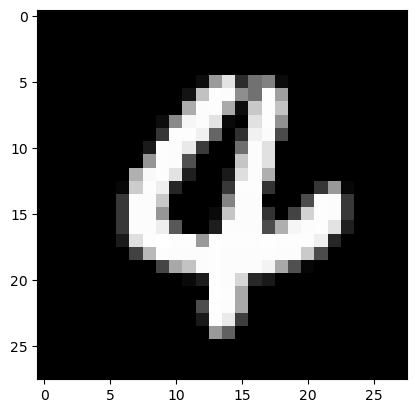

In [312]:
plt.imshow(xb[0].reshape(28, 28));

In [313]:
yb[0]

tensor(4)

In [314]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [315]:
model, opt = get_model()

In [316]:
fit()

0.05, 1.00
0.05, 0.98
0.07, 0.96


In [317]:
for xb, yb in train_dl:
    print(xb.shape)

torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size([50, 784])
torch.Size

In [318]:
report??

Signature: report(loss, preds, yb)
Docstring: <no docstring>
Source:   
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')
File:      /var/folders/c8/mt_y_mg14_s14_slht8ds95w0000gn/T/ipykernel_16402/637282997.py
Type:      function

### Multiprocessing dataloader

In [334]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [335]:
store_attr??

Signature:
store_attr(
    names=None,
    self=None,
    but='',
    cast=False,
    store_args=None,
    **attrs,
)
Source:   
def store_attr(names=None, self=None, but='', cast=False, store_args=None, **attrs):
    "Store params named in comma-separated `names` from calling context into attrs in `self`"
    fr = sys._getframe(1)
    args = argnames(fr, True)
    if self: args = ('self', *args)
    else: self = fr.f_locals[args[0]]
    if store_args is None: store_args = not hasattr(self,'__slots__')
    if store_args and not hasattr(self, '__stored_args__'): self.__stored_args__ = {}
    anno = annotations(self) if cast else {}
    if names and isinstance(names,str): names = re.split(', *', names)
    ns = names if names is not None else getattr(self, '__slots__', args[1:])
    added = {n:fr.f_locals[n] for n in ns}
    attrs = {**attrs, **added}
    if isinstance(but,str): but = re.split(', *', but)
    attrs = {k:v for k,v in attrs.items() if k not in but}
    return _store_attr(s

In [336]:
for o in map(train_ds.__getitem__, ([3, 6], [8, 1])):
    print(o[0].shape)

torch.Size([2, 784])
torch.Size([2, 784])


In [337]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=-1, collate_fn=collate) -> None:
        fc.store_attr()
    
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [338]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))
     

In [339]:
mp.Pool??

Signature:
mp.Pool(
    processes=None,
    initializer=None,
    initargs=(),
    maxtasksperchild=None,
)
Source:   
    def Pool(self, processes=None, initializer=None, initargs=(),
             maxtasksperchild=None):
        '''Returns a process pool object'''
        from .pool import Pool
        return Pool(processes, initializer, initargs, maxtasksperchild,
                    context=self.get_context())
File:      ~/anaconda3/lib/python3.10/multiprocessing/context.py
Type:      method

In [340]:
train_dl = DataLoader(train_ds, batchs=train_sampler, n_workers=1)

In [341]:
it = iter(train_dl)

In [343]:
# xb, yb = next(it)
# xb.shape, yb.shape

### PyTorch dataloader

In [373]:
#| export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [345]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [359]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [360]:
xb,yb = next(iter(train_dl))
xb.shape

torch.Size([50, 784])

In [348]:
model, opt = get_model()
fit()

0.28, 0.94
0.04, 1.00
0.13, 0.92


In [349]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

In [350]:
accuracy??

Signature: accuracy(out, yb)
Docstring: <no docstring>
Source:    def accuracy(out, yb): return (out.argmax(dim=1) == yb).float().mean()
File:      /var/folders/c8/mt_y_mg14_s14_slht8ds95w0000gn/T/ipykernel_16402/1039778300.py
Type:      function

In [352]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, drop_last=True, num_workers=2)

In [353]:
model, opt = get_model()
fit()

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.14, 0.96


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.17, 0.96


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.20, 0.98


In [354]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.20, grad_fn=<NllLossBackward0>), tensor(0.94))

In [363]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

In [364]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

In [365]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp)

In [366]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [367]:
# DataLoader??

### Validation

In [392]:
#| export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            # eval
        
        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                preds = model(xb)
                loss = loss_func(preds, yb)
                n = len(xb)
                count += n
                acc = accuracy(preds, yb)
                tot_acc += acc.item()*n
                tot_loss += loss.item()*n
        
        print(epoch, tot_loss/count, tot_acc/count)
    
    return tot_loss/count, tot_acc/count

In [393]:
#| export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs)
    )

In [394]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)

In [386]:
next(iter(valid_dl))

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
         6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5, 0, 6, 8, 7, 6, 8,
         9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7, 2, 8, 6, 9])]

In [395]:
model, opt = get_model()

In [396]:
fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.17548670867457986 0.9506000030040741
1 0.13478024453856052 0.9609000033140183
2 0.11017083771061152 0.968200004696846
3 0.1121464530704543 0.968200005888939
4 0.10743483421974816 0.9694000071287155


(0.10743483421974816, 0.9694000071287155)

In [397]:
import nbdev; nbdev.nbdev_export()